In this study, The goal was to measure different classification algorithms on given dataset named "hepsiburada-product-comments.cvs". Therefore, I've decided to perform it by measuring on 4 different classifiers. 
<br >Firstly, I developed a classifier with sequantial layers which The model takes in sequences of integers, converts them to dense vectors, and passes them through three GRU layers. The final output is a binary classification prediction. In pre-trained models, It has been decided to use the logistic regression and Naive Bayes classifiers. Finally, as Pre-trained transformer model the BERT has been used. The informations regarding to code parts and tasks are commented above the codes. The results of all models are mention in below table.
<br><br>
| Our developed | Logistic Regression | Naive Bayes | Bert |
|----------|----------|----------|----------|
| 0.98 | 0.98 | 0.97 | 0.93 |

<br><br>
With all respects.<br>
Author and researcher: Nasibulah Qarizada - 1900004691<br>
Istanbul Kultur University<br>



In [83]:
import re
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
import datetime
import tensorflow as tf
from keras.layers import Input, Dense, LSTM, SimpleRNN, Embedding
from keras.layers import Activation, Bidirectional, GlobalMaxPool1D, GlobalMaxPool2D, Dropout
from keras.initializers import Constant
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tokenizers import BertWordPieceTokenizer
import transformers
from transformers import AutoTokenizer
import os 

from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_recall_fscore_support

In [84]:
df = pd.read_csv("C:\\Users\\Nasibullah Qarizada\\Desktop\\hepsiburada-product-comments.csv")
df.head(2)

,Product,reviewText,overall,B1,B2
0,Uno Flip,"Orijinal ürün, hızlı kargo! Oyunu henüz oynama...",5,5,6
1,Uno Flip,"Merhaba, \nDaha önce yapmış olduğum yorumda ka...",5,3,1


<font size="20">Exploratory Analysis</font>

In [85]:

print(f'number of samples:{len(df.reviewText)}')
print(f'number of unique reviewTexts: {df.reviewText.nunique()}')
print(f'percentage of duplicates: {(len(df.reviewText) - df.reviewText.nunique()) / len(df.reviewText)*100}%')

number of samples:947031
number of unique reviewTexts: 790258
percentage of duplicates: 16.554157150082734%


In [86]:
df.shape

(947031, 5)

In [87]:
df.isna().sum()

Product          0
reviewText    5049
overall          0
B1               0
B2               0
dtype: int64

<AxesSubplot:>

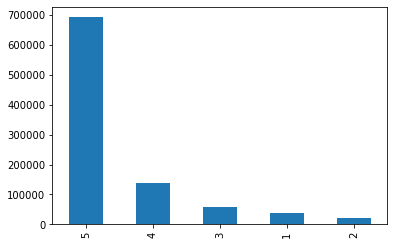

In [88]:
df['overall'].value_counts().plot(kind = 'bar')
#dataset['Product'].value_counts()

<font size="20">Preprocessing</font>


In [89]:
#as first step we start with dropping NAN values.
df = df.dropna()
#Drop column with no potantiality of use.
df = df.drop('B1', axis=1)
df = df.drop('B2', axis=1)

In [90]:
#firtly, we drop all the rows with 3 value since the appear as nuetral values in this study.
df.drop(df[df["overall"] == 3].index, inplace = True)
#we classify the values over 3 as 1, below 3 as 0.
df["overall"] = df["overall"].replace(1, 0)
df["overall"] = df["overall"].replace(2, 0)
df["overall"] = df["overall"].replace(4, 1)
df["overall"] = df["overall"].replace(5, 1)
df["overall"].value_counts()

1    825312
0     60169
Name: overall, dtype: int64

In [91]:
#remove all puncuations
def remove_punctuation(text):
    no_punc = [words for words in text if words not in string.punctuation]
    word_wo_punc = "".join(no_punc)
    return word_wo_punc
#remove numbers
def remove_numeric(corpus):
    output = "".join(words for words in corpus if not words.isdigit())
    return output

#the first 4 lines lower cases, removes the panctuations and replace the \n and \r values as empty spaces to prevent any misunderstandings with the model and last raw drop the numeric values.
df["reviewText"] = df["reviewText"].apply(lambda x: x.lower())
df["reviewText"] = df["reviewText"].apply(lambda x: remove_punctuation(x))
df["reviewText"] = df["reviewText"].apply(lambda x: x.replace("\r", " "))
df["reviewText"] = df["reviewText"].apply(lambda x: x.replace("\n", " "))
df["reviewText"] = df["reviewText"].apply(lambda x: remove_numeric(x))


<font size="20">Train Test Split</font>


In [92]:
target = df["overall"].values.tolist()
data = df["reviewText"].values.tolist()

cutoff = int(len(data)*0.80)

X_train, X_test = data[:cutoff], data[cutoff:]
y_train, y_test = target[:cutoff], target[cutoff:]

In [93]:
#This code sets a maximum number of words, initializes a tokenizer object, and then fits the tokenizer on the input data to create a word index based on the frequency of words.
num_words = 100000
tokenizer = Tokenizer(num_words = num_words)
tokenizer.fit_on_texts(data)


In [94]:
#converts text data in X_train and X_test into sequences of integers using the tokenizer object, 
#and prints the original text of the 10000th element of X_train and its corresponding integer sequence.
X_train_tokens = tokenizer.texts_to_sequences(X_train)
X_test_tokens = tokenizer.texts_to_sequences(X_test)

print([X_train[10000]])
print(X_train_tokens[10000])

['kısa sürede ulaştı kolayca taktım güzel ürün']
[111, 182, 37, 781, 600, 5, 4]


In [95]:
# calculates the number of tokens for each element in the combined X_train_tokens and X_test_tokens lists, and stores them in a NumPy array num_tokens.
num_tokens = [len(tokens) for tokens in X_train_tokens + X_test_tokens]
num_tokens = np.array(num_tokens)
num_tokens

array([18, 37,  4, ..., 10, 21, 14])

In [96]:
#calculates the maximum number of tokens allowed for each sequence by taking the mean of the number of tokens in the num_tokens array, adding two standard deviations, converting the result to an integer, and storing it in the max_tokens variable.
max_tokens = np.mean(num_tokens) + (2*np.std(num_tokens))
max_tokens = int(max_tokens)
max_tokens

60

In [97]:
#padding on the sequences in X_train_tokens and X_test_tokens to ensure they are all of equal length (maxlen), then stores the resulting padded sequences in X_train_pad and X_test_pad.
X_train_pad = pad_sequences(X_train_tokens, maxlen = max_tokens) 
X_test_pad = pad_sequences(X_test_tokens, maxlen = max_tokens)

print(X_train_pad.shape)
print(X_test_pad.shape)

(708384, 60)
(177097, 60)


In [98]:
#This code defines a function that converts a sequence of tokens back into its corresponding text.
idx = tokenizer.word_index
inverse_map = dict(zip(idx.values(), idx.keys()))

def tokens_to_string(tokens):
    words = [inverse_map[token] for token in tokens if token != 0]
    text = " ".join(words) 
    return text

<font size="20">Training the model</font>


In [99]:
embedding_size = 50
model = Sequential()
model.add(Embedding(input_dim = num_words, output_dim = embedding_size, input_length = max_tokens, name = "embedding_layer"))
model.add(GRU(units = 16, return_sequences = True))
model.add(GRU(units = 8, return_sequences = True))
model.add(GRU(units = 4))
model.add(Dense(1, activation = "sigmoid"))

X_train_pad = np.array(X_train_pad)
y_train = np.array(y_train)

model.compile(loss = "binary_crossentropy", optimizer = 'adam', metrics = ["accuracy"])
model.fit(X_train_pad, y_train, epochs = 5, batch_size = 256)

Epoch 1/5
2768/2768 [==============================] - 369s 131ms/step - loss: 0.1168 - accuracy: 0.9633
Epoch 2/5
2768/2768 [==============================] - 434s 157ms/step - loss: 0.0614 - accuracy: 0.9793
Epoch 3/5
2768/2768 [==============================] - 430s 155ms/step - loss: 0.0408 - accuracy: 0.9870
Epoch 4/5
2768/2768 [==============================] - 418s 151ms/step - loss: 0.0275 - accuracy: 0.9916
Epoch 5/5
2768/2768 [==============================] - 432s 156ms/step - loss: 0.0195 - accuracy: 0.9943


In [100]:
# Convert test data to numpy array and pad the sequences
X_test_pad = np.array(X_test_pad)
y_test = np.array(y_test)

# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=0)

# Evaluate the model on test data
y_pred = model.predict(X_test_pad)
y_pred = (y_pred > 0.5).astype(int)

# Print the scores
print('Test Accuracy:', accuracy)

f1 = f1_score(y_test, y_pred)
print('F1 Score:', f1)

cm = confusion_matrix(y_test, y_pred)

print('Classification Report:')
print(classification_report(y_test, y_pred))


Test Accuracy: 0.966481626033783
F1 Score: 0.9819859189123573
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.72      0.76     13089
           1       0.98      0.99      0.98    164008

    accuracy                           0.97    177097
   macro avg       0.89      0.85      0.87    177097
weighted avg       0.97      0.97      0.97    177097



<font size="20">Pre-trained models</font> 

<font size="5">Logistic Regression</font>

In [101]:
# Split the data into training and test sets
cutoff = int(len(data)*0.80)
X_train, X_test = data[:cutoff], data[cutoff:]
y_train, y_test = target[:cutoff], target[cutoff:]

# Convert text data into numerical vectors using CountVectorizer
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Train a logistic regression model
logreg = LogisticRegression(C=1, max_iter=1000)
logreg.fit(X_train_vec, y_train)

# Make predictions on test set and calculate metrics
y_pred = logreg.predict(X_test_vec)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)


# Print metrics and confusion matrix
print('Accuracy:', accuracy)
print('F1 Score:', f1)
print('Confusion Matrix:')
print(cm)
print('Classification Report:')
print(classification_report(y_test, y_pred))


Accuracy: 0.9631727245520816
F1 Score: 0.9802980962680571
Confusion Matrix:
[[  8319   4770]
 [  1752 162256]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.64      0.72     13089
           1       0.97      0.99      0.98    164008

    accuracy                           0.96    177097
   macro avg       0.90      0.81      0.85    177097
weighted avg       0.96      0.96      0.96    177097



<font size="5">Naive Bayes</font>

In [102]:
# Split the data into training and test sets
cutoff = int(len(data)*0.80)
X_train, X_test = data[:cutoff], data[cutoff:]
y_train, y_test = target[:cutoff], target[cutoff:]

# Convert text data into numerical vectors using CountVectorizer
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Train a Naive Bayes model
nb = MultinomialNB()
nb.fit(X_train_vec, y_train)

# Make predictions on test set and calculate metrics
y_pred = nb.predict(X_test_vec)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Print metrics and confusion matrix
print('Accuracy:', accuracy)
print('F1 Score:', f1)
print('Confusion Matrix:')
print(cm)
print('Classification Report:')
print(classification_report(y_test, y_pred))


Accuracy: 0.9519472379543414
F1 Score: 0.9746052019050574
Confusion Matrix:
[[  5288   7801]
 [   709 163299]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.40      0.55     13089
           1       0.95      1.00      0.97    164008

    accuracy                           0.95    177097
   macro avg       0.92      0.70      0.76    177097
weighted avg       0.95      0.95      0.94    177097



<font size="20">Pre-trained transformers model </font>

<font size="5">Bert (Bidirectional Encoder Representation from transformers)</font>

In [103]:
#This function encodes a list of texts into a sequence of token IDs using a given tokenizer, with chunking and padding for efficient processing.
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=23):    
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(length=maxlen)
    all_ids = []
    
    for i in range(0, len(texts), chunk_size):
        text_chunk = texts[i:i+chunk_size]
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)


In [104]:
#This code loads the pre-trained BERT tokenizer and saves it locally, and then creates a fast tokenizer using the same vocabulary file.
tokenizer = transformers.AutoTokenizer.from_pretrained("bert-base-uncased")
save_path = 'bert_base_uncased'
if not os.path.exists(save_path):
    os.makedirs(save_path)
tokenizer.save_pretrained(save_path)

fast_tokenizer = BertWordPieceTokenizer('bert_base_uncased/vocab.txt', lowercase=True)
fast_tokenizer

Tokenizer(vocabulary_size=30522, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=True, wordpieces_prefix=##)

In [105]:
#returns a numpy array with the encoded sequences
X = fast_encode(data, fast_tokenizer, maxlen=23)
X.shape

(885481, 23)

In [106]:
y=df['overall'].to_numpy()

In [107]:
#begin splittin train test as 10/90 ratio.
X_train_valid,X_test,y_train_valid,y_test=train_test_split(X,y,test_size=0.1,random_state=42)
X_train,X_valid,y_train,y_valid=train_test_split(X_train_valid,y_train_valid,test_size=0.2,random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape,X_valid.shape,y_valid.shape

((637545, 23), (88549, 23), (637545,), (88549,), (159387, 23), (159387,))

In [108]:
#loads the bert layer as tensorflow keras layer.
transformer_layer = transformers.TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [109]:
embedding_size = 23
inp = Input(shape=(23, ))
embedding_matrix=transformer_layer.weights[0].numpy()
x = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1],embeddings_initializer=Constant(embedding_matrix),trainable=False)(inp)
x = Bidirectional(LSTM(25, return_sequences=True,recurrent_regularizer='L1L2'))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.9)(x)
x = Dense(50, activation='relu',kernel_initializer='he_normal',kernel_regularizer="L1L2")(x)
x = Dropout(0.9)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[inp], outputs=x)

In [110]:
model.compile(loss='binary_crossentropy',optimizer=Adam(),metrics=['accuracy'])
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 23)]              0         
                                                                 
 embedding_3 (Embedding)     (None, 23, 768)           23440896  
                                                                 
 bidirectional_3 (Bidirectio  (None, 23, 50)           158800    
 nal)                                                            
                                                                 
 global_max_pooling1d_3 (Glo  (None, 50)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_154 (Dropout)       (None, 50)                0         
                                                                 
 dense_8 (Dense)             (None, 50)                2550

In [111]:
#This function creates a TensorBoard callback to be used during training to save log files for visualization.
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [112]:
history=model.fit(X_train,y_train,batch_size=32,epochs=5,validation_data=(X_valid,y_valid),callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, experiment_name="bert_model")]) 

Saving TensorBoard log files to: model_logs/bert_model/20230429-133440
Epoch 1/5
19924/19924 [==============================] - 575s 29ms/step - loss: 0.2426 - accuracy: 0.9311 - val_loss: 0.2023 - val_accuracy: 0.9317
Epoch 2/5
19924/19924 [==============================] - 697s 35ms/step - loss: 0.2093 - accuracy: 0.9328 - val_loss: 0.1804 - val_accuracy: 0.9329
Epoch 3/5
19924/19924 [==============================] - 696s 35ms/step - loss: 0.1958 - accuracy: 0.9358 - val_loss: 0.1695 - val_accuracy: 0.9410
Epoch 4/5
19924/19924 [==============================] - 714s 36ms/step - loss: 0.1882 - accuracy: 0.9384 - val_loss: 0.1585 - val_accuracy: 0.9442
Epoch 5/5
19924/19924 [==============================] - 720s 36ms/step - loss: 0.1837 - accuracy: 0.9399 - val_loss: 0.1556 - val_accuracy: 0.9472


In [113]:
model.evaluate(X_valid,y_valid)

4981/4981 [==============================] - 87s 18ms/step - loss: 0.1556 - accuracy: 0.9472


[0.1555517017841339, 0.9471914172172546]

In [114]:

model_preds = model.predict(X_test)

2768/2768 [==============================] - 53s 18ms/step


In [118]:


def calculate_results(y_true, y_pred): 
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

calculate_results(y_test,tf.squeeze(tf.round(model_preds)))

{'accuracy': 94.77916182000926,
 'precision': 0.943976298407921,
 'recall': 0.9477916182000926,
 'f1': 0.9351242416696955}